In [1]:
import pickle
import numpy as np 
import pandas as pd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
import os 
import glob

mpl.rcParams['figure.figsize'] = (5,5)
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams["image.origin"] = 'lower'

In [2]:
model_dir = "../models/v12_allnew/"
model_name = "v12_allnew"
det = "EE"
model_version = 2
cols = ["seed_eta", "seed_phi", "seed_iz","en_seed","et_seed",
        "cluster_deta", "cluster_dphi", "en_cluster", "et_cluster",
       "seed_f5_r9", "seed_f5_sigmaIetaIeta","seed_f5_sigmaIetaIphi","seed_f5_sigmaIphiIphi",
        "seed_f5_swissCross","seed_nxtals", "seed_etaWidth", "seed_phiWidth",
        "cl_f5_r9", "cl_f5_sigmaIetaIeta","cl_f5_sigmaIetaIphi","cl_f5_sigmaIphiIphi",
        "cl_f5_swissCross", "cl_nxtals", "cl_etaWidth", "cl_phiWidth"]

os.makedirs(model_dir, exist_ok = True)
with open("variables.txt", "w") as of:
    of.write("\n".join(cols))

# Data preparation
## Input: 
- E seed
- eta,phi,z seed
- E cluster
- delta_eta,delta_phi,

Filter only windows with the calo

In [3]:
files_ele = "/storage/ECAL/training_data/electrons/numpy_v15_bis/training/"
files_gamma = "/storage/ECAL/training_data/gammas/numpy_v15_bis/training/"

In [4]:
files_ele = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/electrons/numpy_v9/training/"
files_gamma = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/gammas/numpy_v9/training/"

In [4]:
datas_ele = []

i = 0
for f in glob.glob(files_ele+"*.pkl"):
    d = pickle.load(open(f, "rb"))   
    datas_ele.append(d[d.is_seed == False])
    i+=1
    
data_ele = pd.concat(datas_ele, ignore_index=True)
data_ele["particle"] = "electron"
print("N events ele: ",len(data_ele))

datas_gamma = []
i = 0
for f in glob.glob(files_gamma+"*.pkl"):
    d = pickle.load(open(f, "rb"))  
    datas_gamma.append(d[d.is_seed==False])
    i+=1
    
data_gamma = pd.concat(datas_gamma, ignore_index=True)
data_gamma["particle"] = "gamma"
print("N events gamma: ",len(data_gamma))

if data_ele.shape[0]> data_gamma.shape[0]:
    data = pd.concat([data_gamma, data_ele.iloc[0:len(data_gamma)]], ignore_index=True)
else:
    data = pd.concat([data_gamma.iloc[0:len(data_ele)], data_ele], ignore_index=True)
    
del data_gamma
del data_ele

N events ele:  4731872
N events gamma:  4418528


Balance gamma and electron

In [5]:
data_EB = data[abs(data.seed_eta)<1.479]
data_EE = data[abs(data.seed_eta)>=1.479]

In [6]:
print("Sample in EB:", len(data[abs(data.seed_eta) <1.479]))
print("Sample in EE:", len(data[abs(data.seed_eta) >=1.479]))
print("Sample in EB in SC:", len(data[(abs(data.seed_eta) <1.479)&(data.in_scluster)]))
print("Sample in EE in SC:", len(data[(abs(data.seed_eta) >=1.479)&(data.in_scluster)]))
print("N in supercluster: ", len(data[ data.in_scluster]))
print("N out supercluster: ", len(data[data.in_scluster == False]))
w = len(data[(data.is_seed == False) & (data.in_scluster == False)]) / len(data[(data.is_seed == False) & (data.in_scluster==True)])
print(w)

Sample in EB: 0
Sample in EE: 8837056
Sample in EB in SC: 0
Sample in EE in SC: 865721
N in supercluster:  865721
N out supercluster:  7971335
9.207741293095582


In [7]:
print("caloMatch samples: ", len(data[data.is_calo_matched]))
print("Not caloMatch samples: ", len(data[data.is_calo_matched ==False]))

caloMatch samples:  5409269
Not caloMatch samples:  3427787


# Data Preparation

In [9]:
data_in = data[ (data.is_seed == False) & data.in_scluster]
data_out =  data[(data.is_seed == False) & (data.in_scluster == False)]

In [8]:
data = data_EE

## Balance by et and eta of the seed

In [9]:
etBinning = [0,10,20,30,40,50,60,70,80,90,200]
etaBinning = [-3.0, -2.5, -1.75, -1.479, -0.75, 0.0, 0.75, 1.479, 1.75, 2.5, 3.0]

In [10]:
data["et_bin"] = pd.cut(data.et_seed, etBinning,labels=list(range(len(etBinning)-1)))
data["eta_bin"] = pd.cut(data.seed_eta, etaBinning,labels=list(range(len(etaBinning)-1)))

Text(0.5, 1.0, 'Samples in bins')

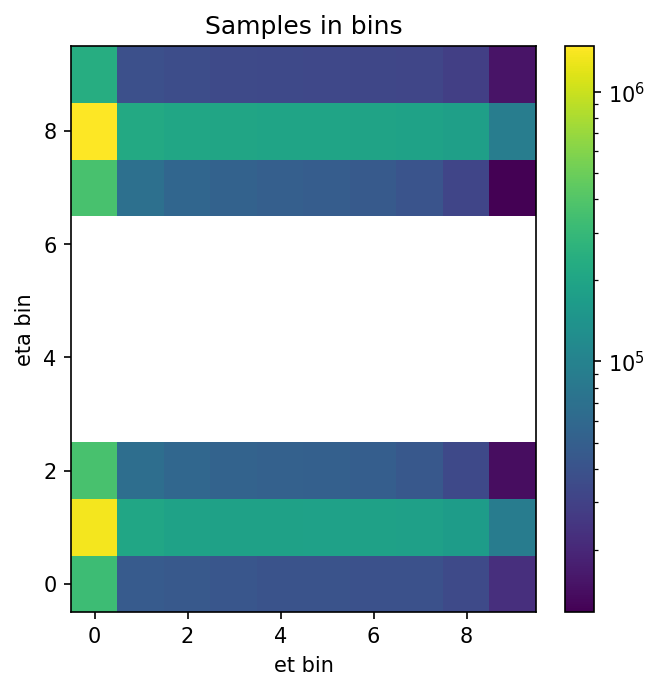

In [11]:
a = data[["et_bin", "eta_bin"]].values.T
hoccupancy = plt.hist2d(a[0], a[1], bins=[10,10], range=[(-.5,9.5),(-.5,9.5)] ,norm= colors.LogNorm())
plt.colorbar()
plt.xlabel("et bin")
plt.ylabel("eta bin")
plt.title("Samples in bins")

Text(0.5, 1.0, 'Samples in bins (out Supercluster)')

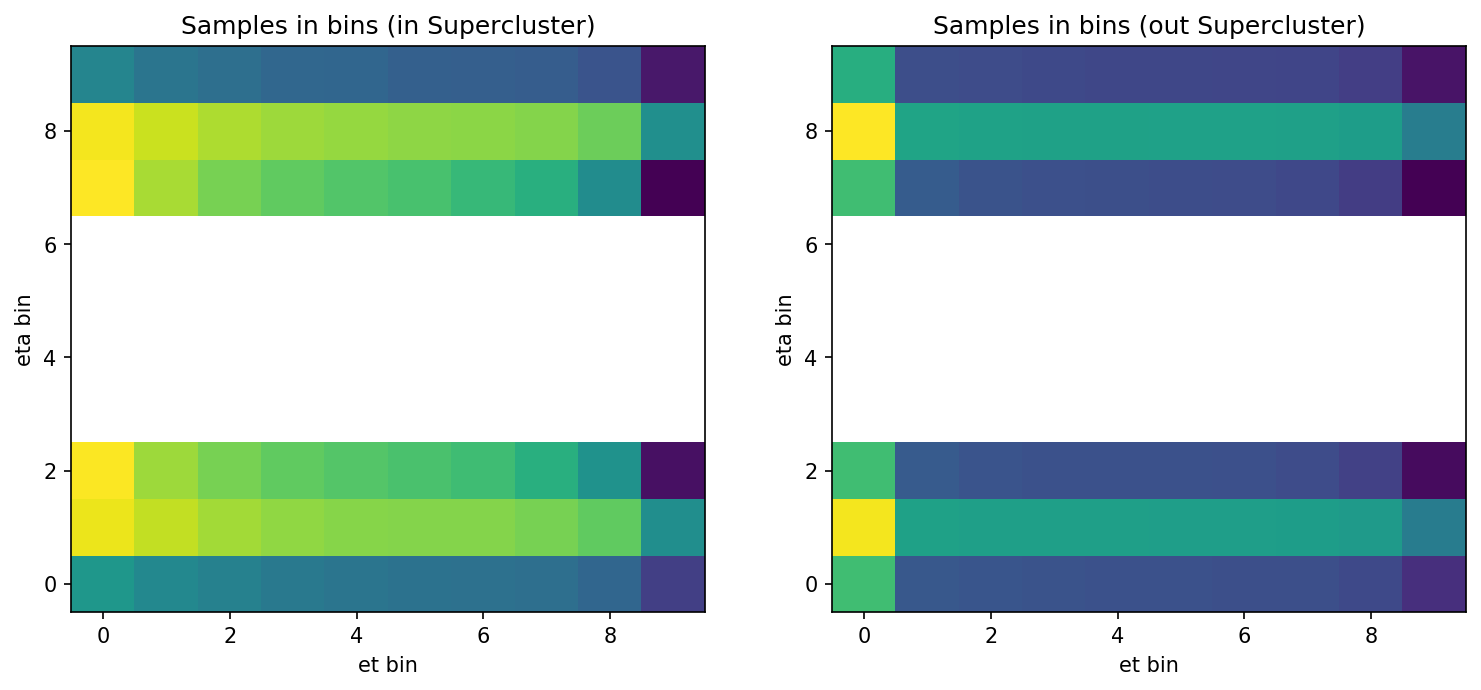

In [12]:
a_in = data[data.in_scluster==True][["et_bin", "eta_bin"]].values.T
a_out = data[data.in_scluster==False][["et_bin", "eta_bin"]].values.T
f, axs = plt.subplots(1,2, figsize=(12,5))
hoccup_in = axs[0].hist2d(a_in[0], a_in[1], bins=[10,10], range=[(-.5,9.5),(-.5,9.5)] ,norm= colors.LogNorm())
axs[0].set_xlabel("et bin")
axs[0].set_ylabel("eta bin")
axs[0].set_title("Samples in bins (in Supercluster)")

hoccup_out= axs[1].hist2d(a_out[0], a_out[1], bins=[10,10], range=[(-.5,9.5),(-.5,9.5)] ,norm= colors.LogNorm())
axs[1].set_xlabel("et bin")
axs[1].set_ylabel("eta bin")
axs[1].set_title("Samples in bins (out Supercluster)")

In [13]:
tot = np.sum(hoccup_in[0] + hoccup_out[0])
cell_tot = tot / 120

In [14]:
weights = np.zeros((10,10,2))
for i in range(0,10):
    for j in range(0,10):
        weights[i,j,0] = cell_tot / hoccup_in[0][i,j]
        weights[i,j,1] = cell_tot / hoccup_out[0][i,j]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """


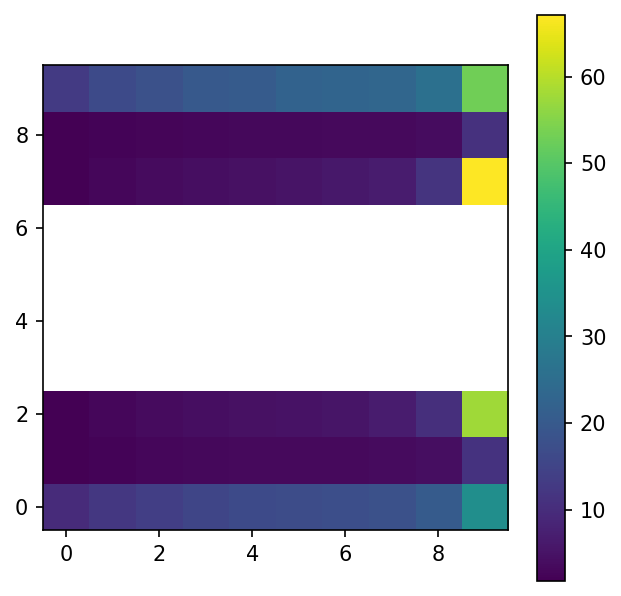

In [15]:
plt.imshow(weights[:,:,0].T)
plt.colorbar()

In [16]:
from pandarallel import pandarallel
pandarallel.initialize(use_memory_fs=False)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
def applyweight_insc(row):
    return weights[int(row.et_bin), int(row.eta_bin), 0]
def applyweight_outsc(row):
    return weights[int(row.et_bin), int(row.eta_bin), 1]

w_in = data[data.in_scluster].parallel_apply(applyweight_insc, axis=1)
print("out")
w_out = data[data.in_scluster ==False].parallel_apply(applyweight_outsc, axis=1)

out


In [18]:
data.loc[data.in_scluster,"w"] = w_in
data.loc[data.in_scluster==False, "w"] = w_out

# Array preparation

In [24]:
data


,calo_seed_index,cl_f5_r9,cl_f5_sigmaIetaIeta,cl_f5_sigmaIetaIphi,cl_f5_sigmaIphiIphi,cl_nxtals,cl_swissCross,cluster_deta,cluster_dphi,cluster_iz,...,seed_f5_sigmaIphiIphi,seed_iz,seed_nxtals,seed_phi,seed_swissCross,window_index,particle,et_bin,eta_bin,w
3,-1,1.000000,0.000000,0.000000,0.000000,1,1.000000,0.000242,-0.246111,-1,...,0.039687,-1,2,0.993276,0.751841,fnugkdgu,gamma,0,1,2.135359
4,-1,1.000000,0.025746,0.000655,0.037499,2,0.451848,-0.178774,0.138692,-1,...,0.039687,-1,2,0.993276,0.751841,fnugkdgu,gamma,0,1,2.135359
7,-1,1.139388,0.045016,-0.000420,0.015058,1,1.000000,-0.046251,0.115087,-1,...,0.039687,-1,2,0.993276,0.751841,fnugkdgu,gamma,0,1,2.135359
9,-1,1.000000,0.000000,0.000000,0.000000,1,1.000000,-0.074259,-0.337123,-1,...,0.039687,-1,2,0.993276,0.751841,fnugkdgu,gamma,0,1,2.135359
10,0,1.728512,0.068250,0.001948,0.057110,1,1.000000,-0.177897,-0.099450,1,...,0.022173,1,11,-0.823558,0.831717,ivpinssh,gamma,5,8,3.729532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22020919,-1,1.000000,0.045569,0.000711,0.084967,3,1.000000,-0.184629,-0.042686,-1,...,0.052480,-1,21,-1.975005,1.000000,agwotjjy,electron,0,0,17.207152
22020920,-1,1.000000,0.045569,0.000711,0.084967,3,1.000000,0.030717,-0.139609,-1,...,0.050619,-1,13,-2.071928,1.000000,jgnopcad,electron,0,0,17.207152
22020922,-1,1.000000,0.068638,0.000875,0.069488,1,1.000000,-0.197631,0.221468,-1,...,0.023076,-1,1,0.248542,0.327192,cfhbknkp,electron,0,0,17.207152
22020927,0,1.317060,0.065095,-0.000060,0.035467,1,1.000000,0.082528,0.180335,1,...,0.025697,1,23,1.777724,0.457754,qshimppd,electron,8,8,4.670866


In [19]:
X = data[ cols ].values
truth = data[["in_scluster"]].values
y = np.array(truth[:], dtype=int)
weights = data.w.values

In [18]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir + "/scaler_model_v{}_EB.pkl".format(model_version), "wb"))

In [20]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(model_dir+"/scaler_model_v{}_EE.pkl".format(model_version), "wb"))

In [27]:
scaler.mean_

array([-4.55792861e-02, -1.17083964e-02, -1.34903935e-02,  1.00161923e+02,
        2.42561384e+01, -8.63536138e-03,  4.48592224e-05,  3.45859337e+00,
        7.37630646e-01,  1.04697022e+00,  3.19432209e-02,  5.39142449e-07,
        3.79630062e-02,  4.91967698e-01,  6.15836829e+00,  3.24158995e+00,
        3.66877393e-02,  9.16334075e-05,  3.95834353e-02,  8.46881736e-01,
        1.84766712e+00])

In [28]:
scaler.scale_

array([2.19135988e+00, 1.80431643e+00, 9.99909001e-01, 1.26802617e+02,
       2.84861755e+01, 1.13600284e-01, 2.17083162e-01, 4.07726804e+00,
       1.02004000e+00, 4.79399721e-01, 1.30861530e-02, 3.85008975e-04,
       1.45566813e-02, 3.99832660e-01, 5.92165725e+00, 1.11050894e+01,
       2.14458584e-02, 6.45316467e-04, 2.24543330e-02, 3.22714857e-01,
       2.58670004e+00])

In [21]:
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(X_scaled, y, weights, test_size=0.2)

### Some plots

(array([316797.37571401,  75271.04419338,  21701.5464943 ,  15025.52726604,
         13057.30633229,  93446.87557249,  89173.50167303,  88324.18191024,
         85787.1148329 ,  85121.12601134,  90378.43207021,  88659.60667912,
         88928.27049388,  87816.72203349,  86069.7687233 ,  88855.71304048,
         88532.54090863,  88981.98149311,  87983.20947122,  87499.35508655,
         88448.74120383,  88140.96374491,  88867.15053637,  88886.66044745,
         87509.28406744,  88242.49369595,  88057.32019503,  89212.41079573,
         88626.26896362,  87714.30634967,  88356.87792771,  88765.52670914,
         89120.83488523,  88353.51234782,  87256.0481301 ,  88686.59009674,
         88714.98927221,  89039.20594946,  88435.72375643,  86976.29092516,
         94619.41469846,  92757.13005102,  89140.35698725,  86254.85106534,
         79081.04719792, 137240.41010595, 114405.65255959,  83502.76197295,
         55125.68586812,  29476.9716554 ]),
 array([  0.,   2.,   4.,   6.,   8.,  10., 

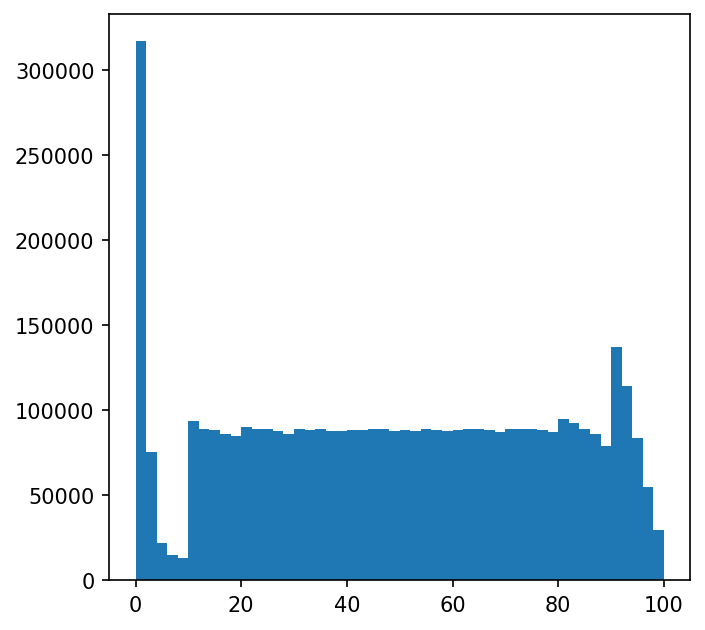

In [23]:
plt.hist(data[data.in_scluster==False].et_seed, bins=50, weights=data[data.in_scluster==False].w, range=(0,100))

# Training

In [24]:
# Import all the required Libraries
import tensorflow
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import callbacks
from keras import backend as K
from keras import regularizers
from keras.callbacks import *

Using TensorFlow backend.


In [26]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               5200      
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)              

In [25]:
model = Sequential()
model.add(Dense(200, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(50, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               5200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

In [50]:
model = Sequential()
model.add(Dense(100, input_dim=X_val.shape[1], activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(100, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))


model.compile(optimizer='adagrad',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               2200      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)              

In [64]:
import math
def step_decay(epoch):
    initial_lrate = 0.35
    drop = 0.7
    epochs_drop = 5.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate < 0.002: return 0.002
    return lrate

In [27]:
auto_save = ModelCheckpoint(model_dir+ "/model_v{}_{}.hd5".format(model_version,det), monitor='val_loss', 
                    verbose=1, save_best_only=True, save_weights_only=False, 
                    mode='auto', period=2)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0002, 
                            patience=10, verbose=1)


#lr_scheduler = callbacks.LearningRateScheduler(step_decay, verbose=1)

history = model.fit(
            X_train, y_train,
            sample_weight = w_train,
            batch_size = 4096,
            epochs=400,
            shuffle=True,
            validation_data = (X_val, y_val, w_val),
            callbacks = [early_stop, auto_save] #lr_scheduler
            )

Train on 7069644 samples, validate on 1767412 samples
Epoch 1/400
7069644/7069644 [==============================] - 39s 6us/step - loss: 0.2881 - accuracy: 0.8878 - val_loss: 0.2333 - val_accuracy: 0.9095
Epoch 2/400
7069644/7069644 [==============================] - 34s 5us/step - loss: 0.2363 - accuracy: 0.8969 - val_loss: 0.2268 - val_accuracy: 0.9167

Epoch 00002: val_loss improved from inf to 0.22675, saving model to ../models/v12_allnew//model_v2_EE.hd5
Epoch 3/400
7069644/7069644 [==============================] - 32s 5us/step - loss: 0.2301 - accuracy: 0.9007 - val_loss: 0.2254 - val_accuracy: 0.9293
Epoch 4/400
7069644/7069644 [==============================] - 32s 5us/step - loss: 0.2264 - accuracy: 0.9031 - val_loss: 0.2189 - val_accuracy: 0.9114

Epoch 00004: val_loss improved from 0.22675 to 0.21888, saving model to ../models/v12_allnew//model_v2_EE.hd5
Epoch 5/400
7069644/7069644 [==============================] - 32s 5us/step - loss: 0.2244 - accuracy: 0.9041 - val_loss

7069644/7069644 [==============================] - 32s 5us/step - loss: 0.2095 - accuracy: 0.9111 - val_loss: 0.2054 - val_accuracy: 0.9175
Epoch 44/400
7069644/7069644 [==============================] - 33s 5us/step - loss: 0.2094 - accuracy: 0.9107 - val_loss: 0.2055 - val_accuracy: 0.9127

Epoch 00044: val_loss improved from 0.20556 to 0.20553, saving model to ../models/v12_allnew//model_v2_EE.hd5
Epoch 45/400
7069644/7069644 [==============================] - 32s 5us/step - loss: 0.2094 - accuracy: 0.9112 - val_loss: 0.2047 - val_accuracy: 0.9073
Epoch 46/400
7069644/7069644 [==============================] - 32s 5us/step - loss: 0.2092 - accuracy: 0.9112 - val_loss: 0.2068 - val_accuracy: 0.9176

Epoch 00046: val_loss did not improve from 0.20553
Epoch 47/400
7069644/7069644 [==============================] - 33s 5us/step - loss: 0.2092 - accuracy: 0.9120 - val_loss: 0.2048 - val_accuracy: 0.9216
Epoch 48/400
7069644/7069644 [==============================] - 33s 5us/step - loss: 

>>> Computing AUC...
AUC score: 0.9979490249887154
>>> Saving ROC curve...


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


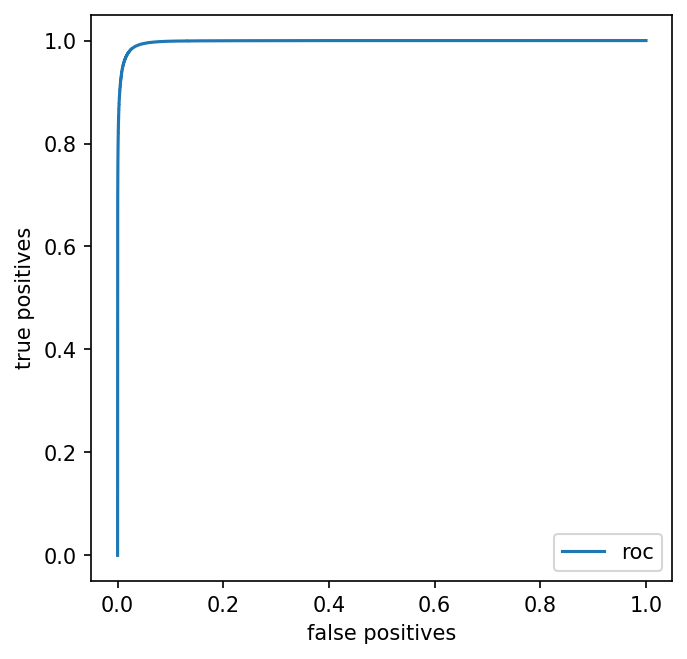

In [26]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred = model.predict(X_val,batch_size=2048)
auc = roc_auc_score(y_val, pred, sample_weight=w_val)
print("AUC score: " + str(auc))

print(">>> Saving ROC curve...")
fp , tp, th = roc_curve(y_val, pred, sample_weight=w_val,drop_intermediate=True)
plt.plot(fp, tp, label="roc")
#plt.plot(fp, th, label="threshold")
plt.xlabel("false positives")
plt.ylabel("true positives")
plt.ylim(-0.05,1.05)

plt.legend()

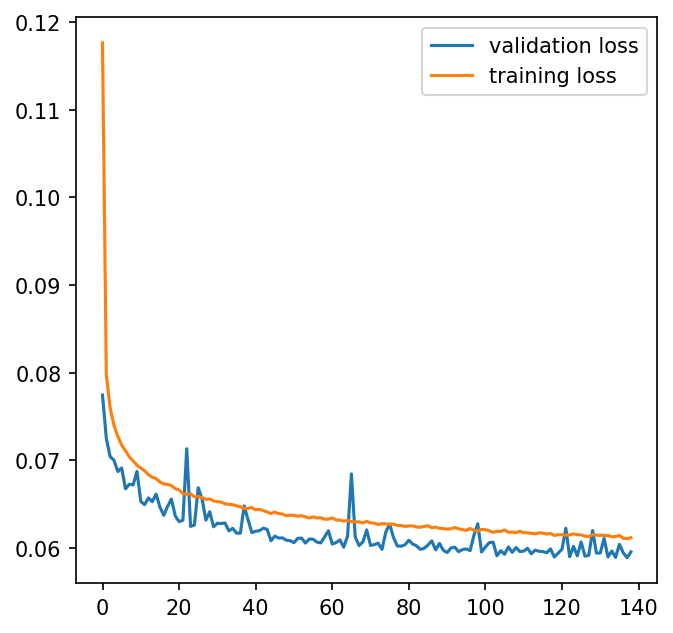

In [25]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

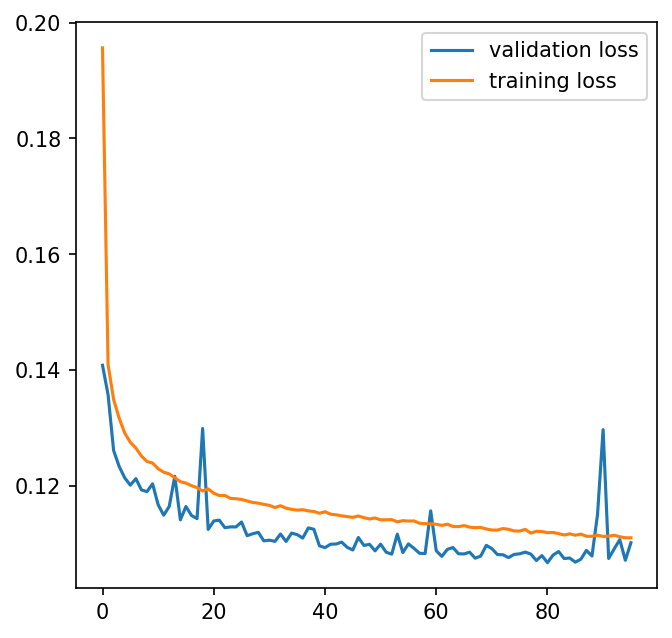

In [29]:
plt.plot(history.epoch, history.history["val_loss"], label="validation loss")
plt.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

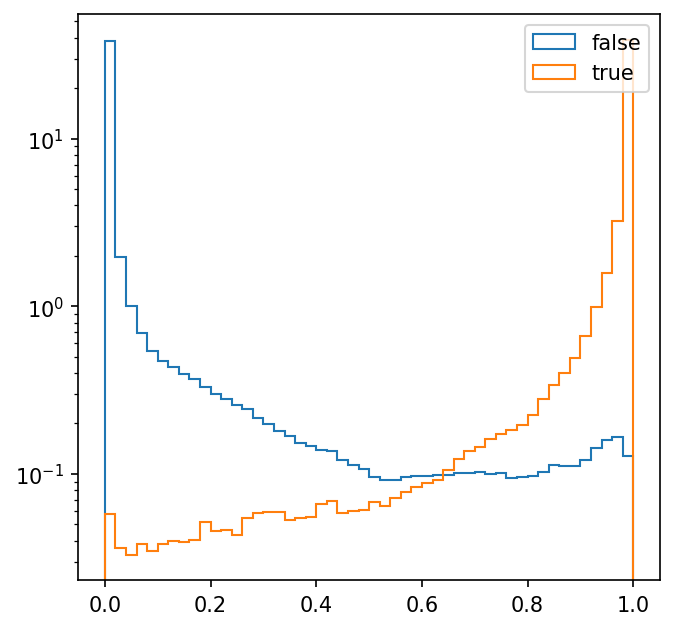

In [27]:
results = model.predict(X_val)
plt.hist(results[y_val==0], bins=50,density=True, label="false", histtype="step")
plt.hist(results[y_val==1], bins=50, density=True, label="true", histtype="step")
plt.yscale("log")
plt.legend()

In [31]:
plt.savefig(model_dir +"/output_model_v1_EE.png")

<Figure size 750x750 with 0 Axes>

# Some plots

In [1]:
from keras.models import load_model
model = load_model("models/model11_balanced_100_80_50.hd5")
scaler = pickle.load(open("models/scaler_gamma_electrons.pkl", "rb"))

Using TensorFlow backend.


OSError: Unable to open file (unable to open file: name = 'models/model11_balanced_100_80_50.hd5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [27]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()

NameError: name 'y_test' is not defined

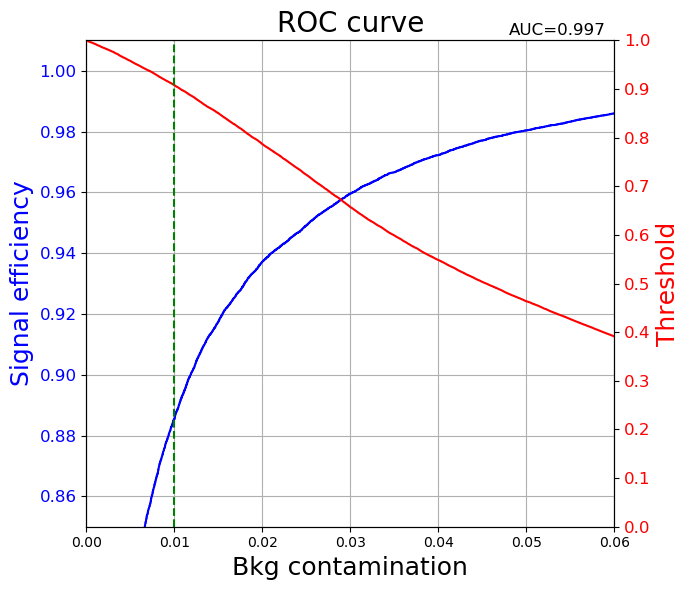

In [36]:
fp , tp, th = roc_curve(y_test, pred)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
ax1.plot(fp, tp, label="roc", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18, color="blue")
ax1.set_ylim(0.850, 1.01)
ax1.set_xlim(0, 0.06)
#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large", labelcolor="blue")

ax2 = ax1.twinx()
ax2.plot(fp, th, label="threshold", color="red")
ax2.tick_params(axis='y', labelcolor="red", labelsize="large")
ax2.set_ylabel("Threshold", fontsize=18, color="red")
ax2.set_ylim(0, 1)
ax1.grid()
#ax2.grid(linestyle="dashed", color="red")

ax2.plot([0.01, 0.01], [0, 2], "g--")
ax2.set_yticks(np.arange(0, 1.1, 0.1))
#ax2.minorticks_on()

ax1.set_title("ROC curve", fontsize=20)
ax2.text(x = 0.048, y = 1.01, s="AUC=0.997", fontsize="large")

fig.tight_layout()